# Coverage of eADAGE LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The eADAGE model uses a DAE to extracts patterns of gene expression activity in the latent variables (referred to as nodes in the paper). Here we are examining the coverage of generic genes within these latent variables.

**Definitions:**
* Generic genes: Are genes that are consistently differentially expressed across multiple simulated experiments.

* Other genes: These are all other non-generic genes. These genes include those that are not consistently differentially expressed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged (i.e. housekeeping genes)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import textwrap
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import lv

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "pseudomonas_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id = params["project_id"]

In [3]:
# Output file
nonzero_figure_filename = "nonzero_LV_coverage_pa.svg"
highweight_figure_filename = "highweight_LV_coverage_pa.svg"

## Load data

In [4]:
# Get gene summary file
summary_data_filename = os.path.join(
    data_dir,
    f"generic_gene_summary_{project_id}_crcZ_v_WT.tsv"
)

In [5]:
# Load gene summary data
data = pd.read_csv(summary_data_filename, sep="\t", index_col=0, header=0)

# Check that genes are unique since we will be using them as dictionary keys below
assert(data.shape[0] == len(data["Gene ID"].unique()))

**Manual steps to process eADAGE data**
1. Data downloaded from https://zenodo.org/record/580093
2. Get Weight matrix (`eADAGE weight matrix.xlsx`) file
3. Save tab (`weight matrix`) as .csv file in `local_dir`

In [6]:
# Load eADAGE weight matrix
eADAGE_weight_filename = os.path.join(local_dir, "eADAGE weight matrix.csv")
eADAGE_weight = pd.read_csv(eADAGE_weight_filename, sep=",", index_col=0, header=0)

In [7]:
eADAGE_weight.shape

(5549, 300)

In [8]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value > 0 for a given LV)
# Most LV have at least half of the genes contributing some amount
(eADAGE_weight > 0).sum().sort_values(ascending=True)

Node34     1970
Node61     2019
Node49     2061
Node198    2064
Node90     2134
Node50     2195
Node56     2204
Node151    2215
Node45     2218
Node31     2235
Node96     2245
Node97     2249
Node191    2272
Node178    2296
Node3      2318
Node1      2329
Node72     2336
Node32     2336
Node259    2337
Node134    2345
Node257    2345
Node147    2350
Node76     2353
Node218    2376
Node78     2377
Node253    2381
Node21     2381
Node172    2384
Node239    2386
Node41     2396
           ... 
Node24     2716
Node44     2719
Node112    2719
Node163    2720
Node169    2723
Node26     2731
Node260    2732
Node77     2736
Node250    2749
Node121    2756
Node265    2766
Node75     2769
Node18     2770
Node25     2770
Node204    2771
Node58     2772
Node249    2772
Node86     2784
Node5      2787
Node252    2798
Node62     2800
Node57     2802
Node155    2817
Node38     2821
Node65     2829
Node203    2832
Node27     2853
Node33     2922
Node28     2940
Node10     3066
Length: 300, dtype: int6

## Get gene data

Define generic genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/pseudomonas_analysis/gene_ranking_logFC.svg) as a guide.

**Definitions:**
* Generic genes: `Rank (simulated) >= 4500` 

(Having a high rank indicates that these genes are consistently changed across simulated experiments.)

* Other genes: `Rank (simulated) < 4500` 

(Having a lower rank indicates that these genes are not consistently changed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged.)

In [9]:
generic_threshold = 4500
dict_genes = lv.get_generic_specific_genes(data, generic_threshold)

(5549, 12)
No. of generic genes: 1051
No. of other genes: 4498


In [10]:
# Check overlap between eADAGE genes and our genes
eADAGE_genes = list(eADAGE_weight.index)
our_genes = list(data.index)
shared_genes = set(our_genes).intersection(eADAGE_genes)

print(len(our_genes))
print(len(shared_genes))

5549
5549


In [11]:
# Drop gene ids not used in eADAGE analysis
processed_dict_genes = lv.process_generic_specific_gene_lists(dict_genes, eADAGE_weight)

In [12]:
# Check numbers add up
assert len(shared_genes) == len(processed_dict_genes["generic"]) + len(processed_dict_genes["other"])

## Get coverage of LVs

For each gene (generic or other) we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to (i.e. the gene is highly weighted within that LV)

### Nonzero LV coverage

In [13]:
dict_nonzero_coverage = lv.get_nonzero_LV_coverage(processed_dict_genes, eADAGE_weight)

In [14]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index
assert len(dict_nonzero_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_nonzero_coverage["other"]) == len(processed_dict_genes["other"])

### High weight LV coverage

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


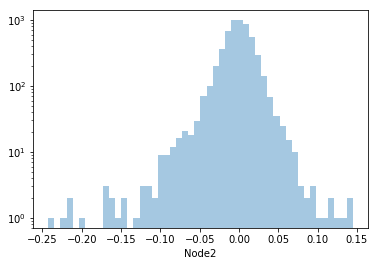

In [15]:
# Quick look at the distribution of gene weights per LV
sns.distplot(eADAGE_weight["Node2"], kde=False)
plt.yscale("log")

In [16]:
dict_highweight_coverage = lv.get_highweight_LV_coverage(processed_dict_genes, eADAGE_weight)

In [17]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_highweight_coverage["generic"].index
assert len(dict_highweight_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_highweight_coverage["other"]) == len(processed_dict_genes["other"])

### Assemble LV coverage and plot

In [18]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label],
        columns= ["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label],
            columns= ["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True
    ) 
    merged_df['gene type'] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [19]:
all_coverage_df = lv.assemble_coverage_df(
    processed_dict_genes,
    dict_nonzero_coverage,
    dict_highweight_coverage
)
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
LocusID,,,
PA3123,146,33,generic
PA0505,172,45,generic
PA3205,160,40,generic
PA0743,144,25,generic
PA5016,160,35,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


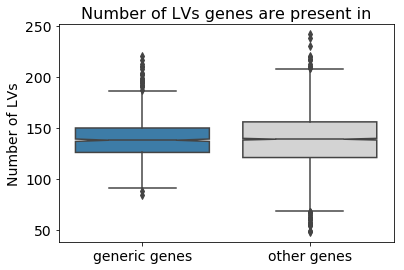

In [20]:
# Plot coverage distribution given list of generic coverage, specific coverage
nonzero_fig = sns.boxplot(
    data=all_coverage_df, 
    x='gene type',
    y='nonzero LV coverage',
    notch=True,
    palette=['#2c7fb8', 'lightgrey']
                         )
nonzero_fig.set_xlabel(None)
nonzero_fig.set_xticklabels(['generic genes', 'other genes'], fontsize=14, fontname="Verdana")
nonzero_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14, fontname="Verdana")
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title("Number of LVs genes are present in", fontsize=16, fontname="Verdana")

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

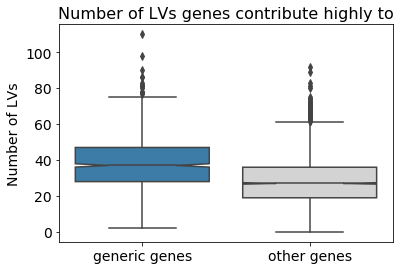

In [21]:
# Plot coverage distribution given list of generic coverage, specific coverage
highweight_fig = sns.boxplot(data=all_coverage_df, 
                             x='gene type',
                             y='highweight LV coverage',
                             notch=True,
                             palette=['#2c7fb8', 'lightgrey']
                            )
highweight_fig.set_xlabel(None)
highweight_fig.set_xticklabels(['generic genes', 'other genes'], fontsize=14, fontname="Verdana")
highweight_fig.set_ylabel(textwrap.fill("Number of LVs", width=30),fontsize=14, fontname="Verdana")
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title("Number of LVs genes contribute highly to", fontsize=16, fontname="Verdana")

## Calculate statistics
* Is the reduction in generic coverage significant?
* Is the difference between generic versus other genes signficant?

In [22]:
# Test: mean number of LVs generic genes present in vs mean number of LVs that generic gene is high weight in
generic_nonzero = all_coverage_df[all_coverage_df["gene type"]=="generic"]["nonzero LV coverage"].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"]=="generic"]["highweight LV coverage"].values

(stats, pvalue) = scipy.stats.ttest_ind(generic_nonzero, generic_highweight)
print(pvalue)

0.0


In [23]:
# Test: mean number of LVs generic genes are high weight in vs mean number of LVs other genes high weight in
other_highweight = all_coverage_df[all_coverage_df["gene type"]=="other"]["highweight LV coverage"].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"]=="generic"]["highweight LV coverage"].values

(stats, pvalue) = scipy.stats.ttest_ind(other_highweight, generic_highweight)
print(pvalue)

9.026260391522518e-111


In [24]:
# Check that coverage of other and generic genes across all LVs is NOT signficantly different
other_nonzero = all_coverage_df[all_coverage_df["gene type"]=="other"]["nonzero LV coverage"].values
generic_nonzero = all_coverage_df[all_coverage_df["gene type"]=="generic"]["nonzero LV coverage"].values

(stats, pvalue) = scipy.stats.ttest_ind(other_nonzero, generic_nonzero)
print(pvalue)

0.2555089115034752


## Get LVs that generic genes are highly weighted in

Since we are using quantiles to get high weight genes per LV, each LV has the same number of high weight genes. For each set of high weight genes, we will get the proportion of generic vs other genes. We will select the LVs that have a high proportion of generic genes to examine. 

In [25]:
# Get proportion of generic genes per LV
prop_highweight_generic_dict = lv.get_prop_highweight_generic_genes(
    processed_dict_genes,
    eADAGE_weight)

In [26]:
proportion_generic = 0.5
generic_LV = []
for k, v in prop_highweight_generic_dict.items():
    if v > proportion_generic:
        print(k, v)
        generic_LV.append(k)

Node198 0.5369369369369369
Node257 0.5153153153153153


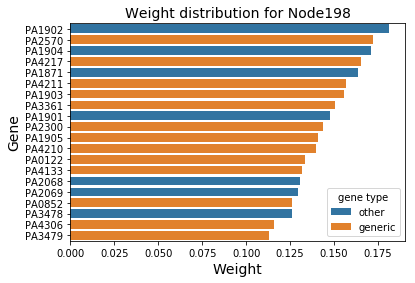

In [27]:
# Plot distribution of weights for these nodes
node = generic_LV[0]
lv.plot_dist_weights(node, eADAGE_weight, 20, all_coverage_df, f"weight_dist_{node}")

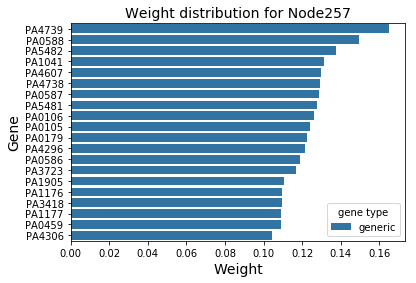

In [28]:
node = generic_LV[1]
lv.plot_dist_weights(node, eADAGE_weight, 20, all_coverage_df, f"weight_dist_{node}")

## Save

In [29]:
# Save plot
nonzero_fig.figure.savefig(
        nonzero_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

# Save plot
highweight_fig.figure.savefig(
        highweight_figure_filename,
        format="svg",
        bbox_inches="tight",
        transparent=True,
        pad_inches=0,
        dpi=300,
    )

**Takeaway:**
* Generic and other genes are present in a similar number of LVs. This isn't surprising since the number of genes that contribute to each LV is <2000 (out of 5549 genes).
* Generic genes are highly weighted in more LVs compared to other genes. WHAT DOES THIS MEAN???

* The LV that was found to contain a high proportion of generic genes are node198 and node257. These nodes don't have an association with any KEGG pathway. WHAT DOES DEB'S GROUP HAVE TO SAY ABOUT THESE?
